# Data Presentation: Zonne-energie op basis van het weer
In dit datavisualisatie project wordt de correlatie tussen de productie van elektriciteit met zonnepanelen en het weer op dat moment onderzocht. Op het einde wordt er een conclusie getrokken waarin dit zal worden aangetoond of weerlegd. Er wordt met Spark (PySpark) gewerkt in een Jupyter Notebook omgeving om de data te preprocessen en te analyseren.

De data is beperkt tot Calgary, Canada gezien ik geen andere kwalitatieve data kon vinden waar ook kwalitatieve historische weerdata voor te vinden was.

De datasets zijn terug te vinden op onderstaande links.
- solar production: https://www.kaggle.com/datasets/ivnlee/solar-energy-production

- weer data: https://calgary.weatherstats.ca/download.html

Onderstaande kaart geeft inzicht over waar de data vandaan komt en zoals we zien zit er 27,59 kilometer tussen de 2 databronnen

In [77]:
import folium 
import geopy.distance
import numpy as np

lat_calgary_station = 51.157807
lon_calgary_station = -114.213362
lat_solar_park = 50.956360
lon_solar_park = -113.983902

solar_loc = (lat_solar_park,lon_solar_park)
weather_loc = (lat_calgary_station,lon_calgary_station)

m = folium.Map([51.1, -114.0], zoom_start=10)

solar = {"prefix": "fa", "color": "green", "icon": "bolt"}
weather = {"prefix": "fa", "color": "orange", "icon": "sun"}

angle = 180
folium.Marker(
    location=[lat_calgary_station, lon_calgary_station],
    tooltip="Click me!",
    popup="Calgary Solar Station",
    icon=folium.Icon(angle=angle, **solar),
).add_to(m)

folium.Marker(
    location=[lat_solar_park, lon_solar_park],
    tooltip="Click me!",
    popup="Calgary Weather Station",
    icon=folium.Icon(angle=angle, **weather),
).add_to(m)

# vogelvlucht
folium.PolyLine(
    locations=[solar_loc, weather_loc],
    color='green',
    weight=5,
    tooltip=str(np.round(geopy.distance.geodesic(solar_loc, weather_loc).km, 2)) + " KM"
).add_to(m)

m


## Imports en Spark innitialiseren

In [78]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, to_date, year, month, expr, when
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.display import Javascript, display
from datetime import datetime
import time

In [79]:
spark = SparkSession.builder.master("local").appName("DataPresentationTaak").getOrCreate()

In [80]:
spark

## 1 Data inladen

In [81]:
data_energy = "../SolarEnergyData/Solar_Energy_Production.csv"
data_weather = "../SolarEnergyData/weatherstats_calgary_dailySince2015.csv"

df_energy = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load(data_energy)
df_weather = spark.read.format("csv").option("header","true").option("inferSchema","true").option("mode","failfast").load(data_weather)

## 2 Data exploratory 

In [82]:
#df_energy.show()
df_energy.printSchema()

root
 |-- name: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- date: string (nullable = true)
 |-- kWh: double (nullable = true)
 |-- public_url: string (nullable = true)
 |-- installationDate: string (nullable = true)
 |-- uid: string (nullable = true)



In [83]:
#df_weather.show()
df_weather.printSchema()

root
 |-- date: date (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- avg_hourly_temperature: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_temperature: double (nullable = true)
 |-- max_humidex: integer (nullable = true)
 |-- min_windchill: integer (nullable = true)
 |-- max_relative_humidity: integer (nullable = true)
 |-- avg_hourly_relative_humidity: double (nullable = true)
 |-- avg_relative_humidity: double (nullable = true)
 |-- min_relative_humidity: integer (nullable = true)
 |-- max_dew_point: double (nullable = true)
 |-- avg_hourly_dew_point: double (nullable = true)
 |-- avg_dew_point: double (nullable = true)
 |-- min_dew_point: double (nullable = true)
 |-- max_wind_speed: integer (nullable = true)
 |-- avg_hourly_wind_speed: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- min_wind_speed: integer (nullable = true)
 |-- max_wind_gust: integer (nullable = true)
 |-- wind_gust_dir_10s: integ

In [84]:
df_energy.count()

258423

In [85]:
df_weather.count()

10000

De energie-productie (df_energy) dataset bevat 258423 records en de weer-dataset (df_weather) bevat er 10000. Bij 'df_energy' gaan we algemener kijken en groeperen per dag, omdat er helaas geen data per uur terug te vinden was over deze periode. Bij 'df_weather' vallen er nog een heel deel records af die buiten het bereik van 'df_energy' liggen. Zie Cleaning stap 3.

### checken op nullwaardes (missing data)

In [86]:
null_columns_e = []

for column in df_energy.columns:
    if df_energy.filter(col(column).isNull()).count() > 0:
        null_columns_e.append(column)

if len(null_columns_e) == 0:
    print("Energy dataset bevat geen kolommen met nullwaardes!")
else:
    print("Energy dataset bevat kolommen met nullwaardes, namelijk de kolommen:\n")
    for column_name in null_columns:
        print(column_name)

Energy dataset bevat geen kolommen met nullwaardes!


In [87]:
null_columns_w = []

for column in df_weather.columns:
    if df_weather.filter(col(column).isNull()).count() > 0:
        null_columns_w.append(column)
        
if len(null_columns_w) == 0:
    print("Weather dataset bevat geen kolommen met nullwaardes!")
else:
    print("Weather dataset bevat kolommen met nullwaardes, namelijk de kolommen:\n")
    for column_name in null_columns_w:
          print(column_name)

Weather dataset bevat kolommen met nullwaardes, namelijk de kolommen:

max_humidex
min_windchill
max_wind_gust
wind_gust_dir_10s
max_health_index
avg_hourly_health_index
avg_health_index
min_health_index
precipitation
rain
snow
snow_on_ground
sunrise_hhmm
sunrise_unixtime
sunrise_f
sunset_hhmm
sunset_unixtime
sunset_f
daylight
min_uv_forecast
max_uv_forecast
min_high_temperature_forecast
max_high_temperature_forecast
min_low_temperature_forecast
max_low_temperature_forecast
solar_radiation
max_cloud_cover_4
avg_hourly_cloud_cover_4
avg_cloud_cover_4
min_cloud_cover_4
max_cloud_cover_8
avg_hourly_cloud_cover_8
avg_cloud_cover_8
min_cloud_cover_8
max_cloud_cover_10
avg_hourly_cloud_cover_10
avg_cloud_cover_10
min_cloud_cover_10


Gelukkig zijn dit geen kolommen die we later nodig hebben dus vormt het niet meteen een probleem. Er moet dus niet aan `imputation` gedaan worden, d.w.z nullwaardes opvullen met:

1. Voor numerieke data:
- Mean imputation: het gemiddelde van de kolom
- Median imputation: de mediaan van de kolom 
- Mode imputation: de mode van de kolom

2. Voor categorische data:
- Frequent category imputation: de waarde die het meest voorkomt in de kolom

### checken op outliers

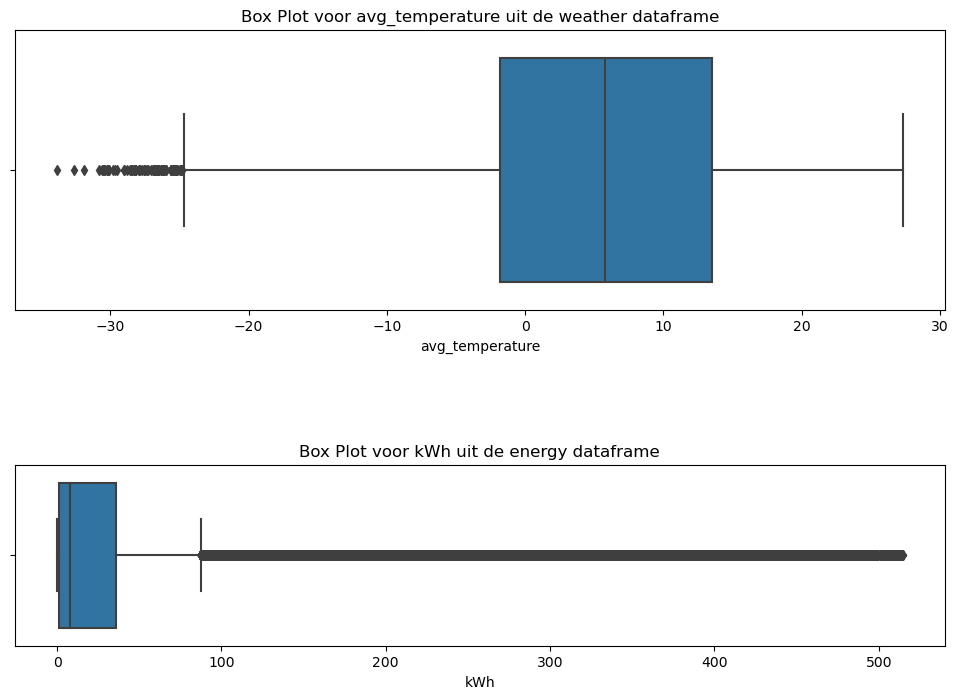

In [88]:
df_weather_bp = df_weather.select("avg_temperature").toPandas()
df_energy_bp = df_energy.select("kWh").toPandas()

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
sns.boxplot(x=df_weather_bp["avg_temperature"]).set_title("Box Plot voor avg_temperature uit de weather dataframe")

plt.subplot(3, 1, 3)
sns.boxplot(x=df_energy_bp["kWh"]).set_title("Box Plot voor kWh uit de energy dataframe")

plt.show()




Uit bovenstaande boxplots kan je afleiden dat er dus wel wat outliers zijn voor beide kolommen. Er zijn heel wat outliers aan de negatieve kant, waarschijnlijk door strenge winterperiodes typisch voor Canada. De boxplot voor het opwekken van stroom lijkt zeer realistisch te zijn gezien er elke dag wel (een beetje) stroom opgewekt wordt en je niet onder 0 kan gaan met opwekken. Wel heb je hier meer outliers op waarschijnlijk heel zonnige dagen waar er heel veel meer wordt opgewekt.

### verdeling temperatuur

In [89]:
# ik heb het uiteindelijkj met .ToPandas() gedaan om te plotten want ik kreeg een "python mismatching 3.9 3.11" error 
# bij df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect() 

"""
column_data = df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(column_data, bins=20, color='blue', edgecolor='black', alpha=0.7)

# Formatting
plt.title('Histogram of Column Name')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


#----


from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
hist(ax, df_weather.select('avg_temperature'), bins = 20, color=['red'])
"""

# error Python in worker has different version (3, 11) than that in driver 3.9, PySpark cannot run with different minor versions.
# Please check environment variables PYSPARK_PYTHON and PYSPARK_DRIVER_PYTHON are correctly set.

"\ncolumn_data = df_weather.select('avg_temperature').rdd.flatMap(lambda x: x).collect()\n\n# Plotting the histogram\nplt.figure(figsize=(10, 6))\nplt.hist(column_data, bins=20, color='blue', edgecolor='black', alpha=0.7)\n\n# Formatting\nplt.title('Histogram of Column Name')\nplt.xlabel('Values')\nplt.ylabel('Frequency')\nplt.grid(True)\nplt.show()\n\n\n#----\n\n\nfrom pyspark_dist_explore import hist\nimport matplotlib.pyplot as plt\n\nfig, ax = plt.subplots()\nhist(ax, df_weather.select('avg_temperature'), bins = 20, color=['red'])\n"

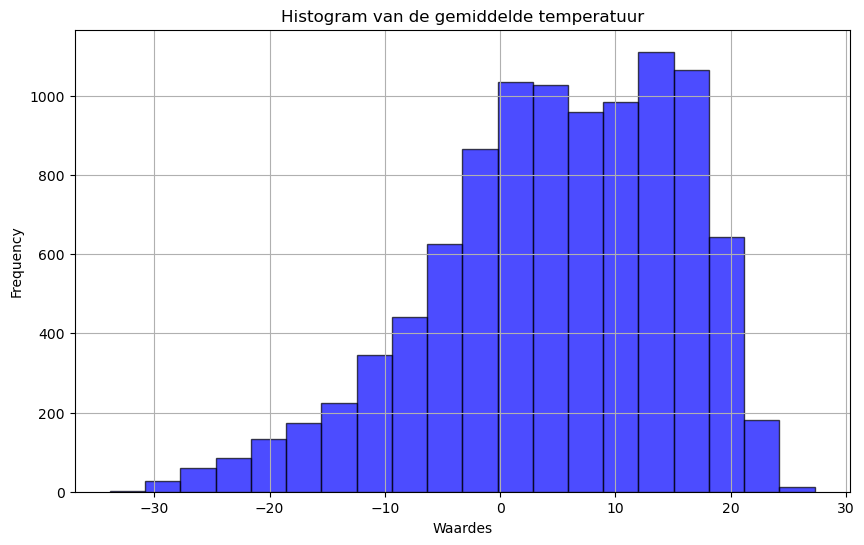

In [90]:
column_data = df_weather.select('avg_temperature').toPandas()


plt.figure(figsize=(10, 6))
plt.hist(column_data['avg_temperature'], bins=20, color="blue", edgecolor='black', alpha=0.7)

plt.title('Histogram van de gemiddelde temperatuur')
plt.xlabel('Waardes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

De meeste metingen zitten dus tussen de 0 en 20°C. Het lijkt erop dat de data "bimodaal" verdeeld is.

### verdeling opwekking zonne-energie

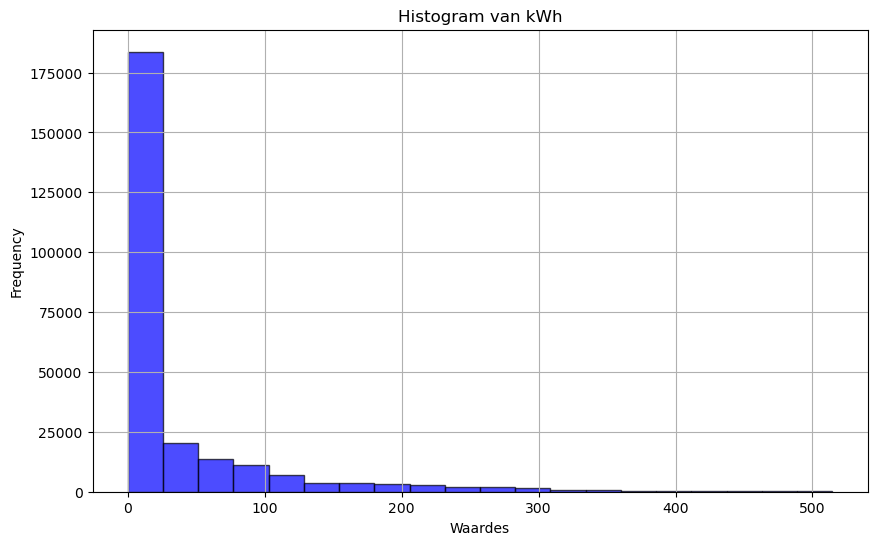

In [91]:
column_data = df_energy.select('kWh').toPandas()

plt.figure(figsize=(10, 6))
plt.hist(column_data['kWh'], bins=20, color='blue', edgecolor='black', alpha=0.7)

plt.title('Histogram van kWh')
plt.xlabel('Waardes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Er zijn meer metingen waarbij er maar weinig stroom wordt opgewekt. De data is dus 'left-skewed'

## 3 cleaning & preprocessing

### date kolom aanpassen

In [92]:
df_energy.select("date").orderBy("date").show()

+--------------------+
|                date|
+--------------------+
|2015/09/01 02:30:...|
|2015/09/01 03:30:...|
|2015/09/01 04:30:...|
|2015/09/01 05:30:...|
|2015/09/01 06:30:...|
|2015/09/01 07:30:...|
|2015/09/01 08:30:...|
|2015/09/01 09:30:...|
|2015/09/01 10:30:...|
|2015/09/01 11:30:...|
|2015/09/02 01:30:...|
|2015/09/02 01:30:...|
|2015/09/02 02:30:...|
|2015/09/02 02:30:...|
|2015/09/02 03:30:...|
|2015/09/02 04:30:...|
|2015/09/02 05:30:...|
|2015/09/02 06:30:...|
|2015/09/02 06:30:...|
|2015/09/02 07:30:...|
+--------------------+
only showing top 20 rows



df_energy datums nog omzetten (casten) naar een date want deze kolom staat oorspronkelijk in het unixtime formaat met `yyyy/MM/dd hh:mm:ss a`en er moet iets van het type date `yyyy/MM/dd` bekomen worden zoals we in de df_weather hebben. Zo kan de data later worden samengevoegd op basis van gelijke datums.

In [93]:
df_energy = df_energy.withColumn("date2", from_unixtime(unix_timestamp(col("date"), 'yyyy/MM/dd hh:mm:ss a')).cast("date"))

df_energy.select("date2").show()

+----------+
|     date2|
+----------+
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-11|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
|2017-09-12|
+----------+
only showing top 20 rows



### data uit df_energy groeperen per dag
Er wordt verder gerekend met de gemiddelde kWh per dag in df_energy, gezien we niet van elk uur weerdata ter beschikking hebben.
Zoals we ook al bij het inladen konden zien bevat df_energy 258423 rijen (omdat er meerdere metingen zijn per dag) en df_weather 10000 rijen, per dag 1 record.

In [94]:
df_energy = df_energy.withColumn("date2", from_unixtime(unix_timestamp(col("date"), 'yyyy/MM/dd hh:mm:ss a')).cast("date"))
# groepeer per dag en bereken average temperature per dag
df_energy_day = df_energy.groupBy("date2").agg({"kWh": "avg"}).orderBy("date2")#.show() returnt een NoneType, hierdoor kan er later nioet mee gewerkt worden! 

df_energy_day.show()

+----------+------------------+
|     date2|          avg(kWh)|
+----------+------------------+
|2015-09-01|28.601300000000002|
|2015-09-02| 32.45933333333333|
|2015-09-03|30.852666666666657|
|2015-09-04|            5.1224|
|2015-09-05|4.9174736842105276|
|2015-09-06|           18.3813|
|2015-09-07|30.262947368421052|
|2015-09-08|           24.4907|
|2015-09-09|           36.6001|
|2015-09-10|  33.0881052631579|
|2015-09-11| 45.54736842105263|
|2015-09-12| 44.59063157894737|
|2015-09-13|13.285210526315788|
|2015-09-14|  5.36278947368421|
|2015-09-15| 32.56542105263158|
|2015-09-16| 35.77613333333333|
|2015-09-17| 50.94357142857143|
|2015-09-18| 50.00066666666666|
|2015-09-21| 45.08325000000001|
|2015-09-22|60.640538461538455|
+----------+------------------+
only showing top 20 rows



In [95]:
df_energy_day.count()

2716

### data buiten bereik filteren
Dagen uit df_weather verwijderen die buiten het bereik van df_energy vallen.


In [96]:
# temp table
df_weather.createOrReplaceTempView("weather_table")
df_energy_day.createOrReplaceTempView("energy_table")

#SQL queries
query_w = """
    SELECT
        MIN(CAST(date AS DATE)) AS min_date,
        MAX(CAST(date AS DATE)) AS max_date
    FROM
        weather_table
"""

query_e = """
    SELECT
        MIN(CAST(date2 AS DATE)) AS min_date,
        MAX(CAST(date2 AS DATE)) AS max_date
    FROM
        energy_table
"""

# Execute SQL
date_min_max_w = spark.sql(query_w).first()
date_min_max_e = spark.sql(query_e).first()

min_date_w = date_min_max_w.min_date
max_date_w = date_min_max_w.max_date
min_date_e = date_min_max_e.min_date
max_date_e = date_min_max_e.max_date

records_df_energy = df_energy_day.count()
records_df_weather = df_weather.count()

print(f"Minimum datum uit df_weather is: {min_date_w}")
print(f"Maximum datum uit df_weather is: {max_date_w}")
print(f"Minimum datum uit df_energy_day is: {min_date_e}")
print(f"Maximum datum uit df_energy_day is: {max_date_e}")
print(f"\nAantal overgebleven records uit df_energy na groepering per dag is: {records_df_energy}")
print(f"Aantal records uit df_weather is: {records_df_weather}")

Minimum datum uit df_weather is: 1996-07-13
Maximum datum uit df_weather is: 2023-11-28
Minimum datum uit df_energy_day is: 2015-09-01
Maximum datum uit df_energy_day is: 2023-03-16

Aantal overgebleven records uit df_energy na groepering per dag is: 2716
Aantal records uit df_weather is: 10000


Nu zijn er meer 'weather' records dan 'energy' records en moet de data buiten het bereik van van de dagen waarvoor er energie-data is, uitgefilterd worden.

Er hoeft niet speciaal nog een drop operatie gedaan worden om de data te verwijderen die niet matcht aangezien er later nog gejoind zal worden en de data die overeenkomt automatisch overblijft.

### niet-relevante kolommen uitfilteren

Voor dit project zijn we enkel geinteresseerd in de `avg_temperature` kolom uit `df_weather`. Natuurlijk zijn er heel wat andere kolommen die ook invloed hebben op de energieproductie van zonnepanelen maar we willen juist de correlatie bespreken tussen een warme dag of een koude dag en de daarbij horende hoeveelheid energie die opgewekt wordt.

er zijn een paar kolommen kandidaat, zoals:
- avg_cloud_cover
- avg_visibility
- solar_radiation
- ...

In [97]:
df_weather.describe()

DataFrame[summary: string, max_temperature: string, avg_hourly_temperature: string, avg_temperature: string, min_temperature: string, max_humidex: string, min_windchill: string, max_relative_humidity: string, avg_hourly_relative_humidity: string, avg_relative_humidity: string, min_relative_humidity: string, max_dew_point: string, avg_hourly_dew_point: string, avg_dew_point: string, min_dew_point: string, max_wind_speed: string, avg_hourly_wind_speed: string, avg_wind_speed: string, min_wind_speed: string, max_wind_gust: string, wind_gust_dir_10s: string, max_pressure_sea: string, avg_hourly_pressure_sea: string, avg_pressure_sea: string, min_pressure_sea: string, max_pressure_station: string, avg_hourly_pressure_station: string, avg_pressure_station: string, min_pressure_station: string, max_visibility: string, avg_hourly_visibility: string, avg_visibility: string, min_visibility: string, max_health_index: string, avg_hourly_health_index: string, avg_health_index: string, min_health_in

In [98]:
#kolommen die we niet nodig hebben uitfilteren
df_weather_selected_col = df_weather.select("date", "avg_temperature")

### joinen op basis van datum

In [99]:
energy = df_energy_day.alias("df_energy_day")
weer = df_weather_selected_col.alias("df_weather")

# inner join on 'date' kolom
joined_df = energy.join(weer, energy['date2'] == weer['Date'], 'left')

joined_df.select(energy['date2'], energy['avg(kWh)'], weer['avg_temperature']).orderBy("date2").show()

+----------+------------------+---------------+
|     date2|          avg(kWh)|avg_temperature|
+----------+------------------+---------------+
|2015-09-01|28.601300000000002|          14.64|
|2015-09-02| 32.45933333333333|          15.45|
|2015-09-03|30.852666666666657|           9.19|
|2015-09-04|            5.1224|           5.69|
|2015-09-05|4.9174736842105276|            3.7|
|2015-09-06|           18.3813|            5.0|
|2015-09-07|30.262947368421052|           9.94|
|2015-09-08|           24.4907|           10.8|
|2015-09-09|           36.6001|           13.3|
|2015-09-10|  33.0881052631579|           12.1|
|2015-09-11| 45.54736842105263|           16.8|
|2015-09-12| 44.59063157894737|          19.14|
|2015-09-13|13.285210526315788|          10.15|
|2015-09-14|  5.36278947368421|            5.9|
|2015-09-15| 32.56542105263158|           8.55|
|2015-09-16| 35.77613333333333|            7.0|
|2015-09-17| 50.94357142857143|           8.15|
|2015-09-18| 50.00066666666666|         

In [100]:
# we hebben nu 2 datum kolommen dus 1tje mag verwijderd worden
joined_df = joined_df.drop(col("date2"))

In [101]:
#joined_df.show()
joined_df.describe().show()

+-------+------------------+-----------------+
|summary|          avg(kWh)|  avg_temperature|
+-------+------------------+-----------------+
|  count|              2716|             2716|
|   mean| 32.60636546059805|4.664900589101617|
| stddev|21.998459233839053|11.01423654777967|
|    min|               0.0|           -30.45|
|    max|  84.8148034188034|            27.29|
+-------+------------------+-----------------+



### datatypes toekennen

In [102]:
column_data_types = joined_df.dtypes

for column, data_type in column_data_types:
    print(f"Kolom: {column}, Data Type: {data_type}")

Kolom: avg(kWh), Data Type: double
Kolom: date, Data Type: date
Kolom: avg_temperature, Data Type: double


Zo te zien bevat deze dataframe al automatisch de juiste datatypes om mee aan de slag te gaan. 

### kolommen toevoegen

In [103]:
df_with_season = joined_df.withColumn("month", expr("month(date)"))

spring_condition = (col("month") >= 3) & (col("month") <= 5)
summer_condition = (col("month") >= 6) & (col("month") <= 8)
autumn_condition = (col("month") >= 9) & (col("month") <= 11)

joined_df = df_with_season.withColumn("seizoen", 
    when(spring_condition, "lente")
    .when(summer_condition, "zomer")
    .when(autumn_condition, "herfst")
    .otherwise("winter")
)

joined_df.show()      

+------------------+----------+---------------+-----+-------+
|          avg(kWh)|      date|avg_temperature|month|seizoen|
+------------------+----------+---------------+-----+-------+
|34.126020833333335|2017-09-11|          18.64|    9| herfst|
| 61.16932075471698|2017-08-11|           18.7|    8|  zomer|
| 42.58591666666667|2016-03-01|          -0.59|    3|  lente|
|61.045993464052316|2019-06-04|           16.0|    6|  zomer|
|           66.2803|2018-05-28|           20.0|    5|  lente|
| 54.34225641025642|2018-08-10|          26.15|    8|  zomer|
| 53.71429411764706|2021-06-22|           21.6|    6|  zomer|
| 48.74009210526314|2019-05-08|           7.25|    5|  lente|
|37.910468468468466|2021-10-11|           0.95|   10| herfst|
|62.834886666666655|2020-08-24|          20.25|    8|  zomer|
|1.8028571428571432|2021-12-18|          -9.19|   12| winter|
| 23.22218681318681|2021-11-13|           3.45|   11| herfst|
| 3.548602564102563|2021-01-27|          -13.2|    1| winter|
|  32.09

## 4 Visualisatie

In [104]:
# checken of dagen uniek zijn (controle voor de plot)
column_name = "date"

unique_count = joined_df.select(column_name).distinct().count()
total_count = joined_df.select(column_name).count()

if unique_count == total_count:
    print(f"Alle waarden in kolom '{column_name}' zijn uniek.")
else:
    print(f"Niet alle waarden in kolom '{column_name}' zijn uniek.")

Alle waarden in kolom 'date' zijn uniek.


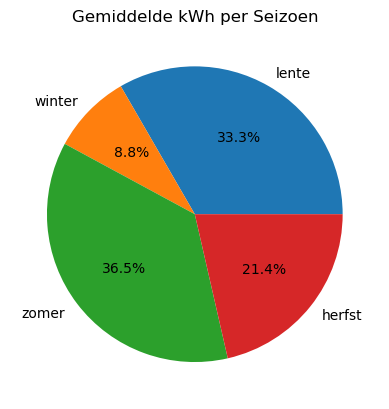

In [105]:
avg_kwh_per_season = joined_df.groupBy("seizoen").agg({"avg(kWh)": "avg"}).toPandas()

# pie chart
plt.pie(avg_kwh_per_season["avg(avg(kWh))"], labels=avg_kwh_per_season["seizoen"], autopct='%1.1f%%')
plt.title('Gemiddelde kWh per Seizoen')
plt.show()

Je ziet duidelijk dat er meer stroom opgewekt wordt tijdens de zomer en lente dan in de winter en herfst periode.

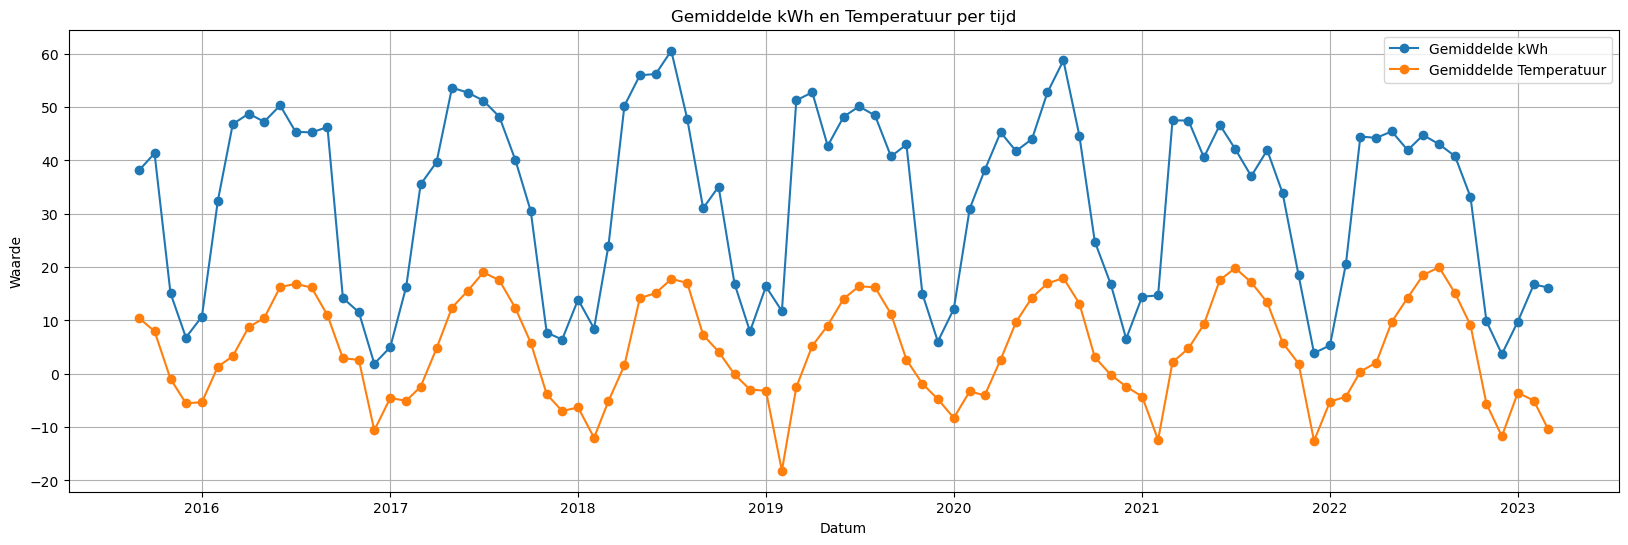

In [106]:
# Groepeer data per jaar en maand om gemiddelde te berekenen
df_plot = joined_df.groupBy(year('date').alias('year'), month('date').alias('month')).agg({'avg(kWh)': 'avg', 'avg_temperature': 'avg'})

# Extract data
dates = [datetime(row.year, row.month, 1) for row in df_plot.collect()]  
avg_kWh_values = [row['avg(avg(kWh))'] for row in df_plot.collect()]
avg_temperature_values = [row['avg(avg_temperature)'] for row in df_plot.collect()]

# Sorteren
sorted_dates, sorted_avg_kWh, sorted_avg_temperature = zip(*sorted(zip(dates, avg_kWh_values, avg_temperature_values)))

plt.figure(figsize=(20, 6))
plt.plot(sorted_dates, sorted_avg_kWh, label='Gemiddelde kWh', marker='o')
plt.plot(sorted_dates, sorted_avg_temperature, label='Gemiddelde Temperatuur', marker='o')

plt.title('Gemiddelde kWh en Temperatuur per tijd')
plt.xlabel('Datum')
plt.ylabel('Waarde')
plt.legend()
plt.grid(True)
plt.show()


opm: Je ziet hier duidelijk een steeds terugkomend patroon in de data. Zowel voor de gemiddelde opwekking van zonne-energie als uiteraard ook de temperatuur (denk aan zomer- en wintertemperaturen). We kunnen dus zeggen dat er dus zeer waarschijnlijk onrechtstreeks ook een correlatie zal bestaan tussen de tijd (de seizoenen) en de hoeveelheid zonne-energie die wordt opgewekt. Natuurlijk is dit omwille van de temperatuur (en andere zaken zoals lichtsterkte, bewolking, uren zonlicht,...) in deze seizoenen. 

In [107]:
# min en max jaar voor widget
distinct_years = joined_df.select(year('date').alias('year')).distinct().toPandas()['year'].tolist()
min_year, max_year = min(distinct_years), max(distinct_years)

year_range_slider = widgets.IntRangeSlider(
    min=min_year,
    max=max_year,
    value=[min_year, max_year],
    step=1,
    description='Selecteer interval: ',
    continuous_update=False
)

# Output widget voor de plot weer te geven
output = widgets.Output()

progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=9,
    step=1,
    description='Loading: ',
    bar_style='info',
    orientation='horizontal'
)

# update functie wanneer year_range_slider wordt aangepast
def update_plot(year_range):
    with output:
        clear_output(wait=True)
        
        filtered_df = joined_df.filter((year(joined_df['date']) >= year_range[0]) & (year(joined_df['date']) <= year_range[1]))

        # Groepeer data per jaar en maand om gemiddelde te berekenen
        df_plot = filtered_df.groupBy(year('date').alias('year'), month('date').alias('month')).agg({'avg(kWh)': 'avg', 'avg_temperature': 'avg'})

        # Sorteren
        df_plot = df_plot.orderBy('year', 'month')

        # Extract data
        dates = [f"{row.year}-{row.month:02d}" for row in df_plot.collect()]
        avg_kWh_values = [row['avg(avg(kWh))'] for row in df_plot.collect()]
        avg_temperature_values = [row['avg(avg_temperature)'] for row in df_plot.collect()]
        
        display(progress_bar)
        
        # Automatisch naar 9
        for i in range(10):
            progress_bar.value = i
            time.sleep(0.5)  # Aan te passen

        plt.figure(figsize=(20, 6))
        plt.plot(dates, avg_kWh_values, label='Gemiddelde kWh', marker='o')
        plt.plot(dates, avg_temperature_values, label='Gemiddelde temperatuur', marker='o')

        plt.title('Gemiddelde kWh en Temperatuur per tijd')
        plt.xlabel('Datum')
        plt.ylabel('Waardes')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
        
        progress_bar.value = 9

# Connect the function to the widget's value
widgets.interact(update_plot, year_range=year_range_slider)

display(output)


interactive(children=(IntRangeSlider(value=(2015, 2023), continuous_update=False, description='Selecteer inter…

Output()

## 5 Correlatie


In [108]:
correlation_value = joined_df.stat.corr("avg(kWh)", "avg_temperature")

print(f"Correlatie tussen average Kwh en de temperatuur is: {correlation_value}")

Correlatie tussen average Kwh en de temperatuur is: 0.6772647080391323


Men kan hier dus spreken van een redelijk sterke correlatie tussen de temperatuur en de hoeveelheid energie die opgewekt wordt. Als de temperatuur verhoogt, verhoogt dus ook de hoeveelheid kWh die opgewekt wordt.

In [109]:
### kan alleen matrix printen als er meerder kolommen zijn (dat je een dataframe terug krijgt, met 2 kolommen krijg je gwn een float terug)
"""
correlation_matrix = joined_df.stat.corr("avg(kWh)", "","","", "avg_temperature")

print("Correlation Matrix:")
correlation_matrix.show()
"""

'\ncorrelation_matrix = joined_df.stat.corr("avg(kWh)", "","","", "avg_temperature")\n\nprint("Correlation Matrix:")\ncorrelation_matrix.show()\n'

## ML

In [110]:
# Lag the 'avg(kWh)' column to capture temporal patterns
window = Window().orderBy("date")
lagged_df = joined_df.withColumn("lagged_kWh", lag("avg(kWh)").over(window))

lagged_df = lagged_df.na.drop()

# Assemble features
feature_cols = ["lagged_kWh", "avg_temperature"]
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(featuresCol="features", labelCol="avg(kWh)")

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, rf_model])

train_data, test_data = lagged_df.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("date", "avg(kWh)", "prediction").show()


+----------+--------------------+------------------+
|      date|            avg(kWh)|        prediction|
+----------+--------------------+------------------+
|2017-01-07|                 0.0|2.7824650138672413|
|2015-12-19|               0.001| 3.160052722281408|
|2015-12-29|              0.0014|3.1085584925859227|
|2019-12-12|0.004727272727272...| 3.160052722281408|
|2022-01-01|               0.042|3.1085584925859227|
|2016-12-15| 0.05960000000000001|2.7824650138672413|
|2016-01-07| 0.13933333333333334| 8.592100360275268|
|2022-01-06| 0.20020000000000002|1.9093835403116883|
|2015-12-27|  0.2836666666666667|6.5617670224461815|
|2016-12-04|              0.2945| 8.968160991518237|
|2021-12-28| 0.30000000000000004|1.9618031358009032|
|2022-12-05|  0.3123333333333333|10.884255018289556|
|2016-12-16|             0.31875|1.9093835403116883|
|2016-12-17|  0.3338095238095239|2.7824650138672413|
|2023-02-20|  0.4294531250000001| 24.66920162729921|
|2017-01-16|  0.4598888888888889|12.4291923325

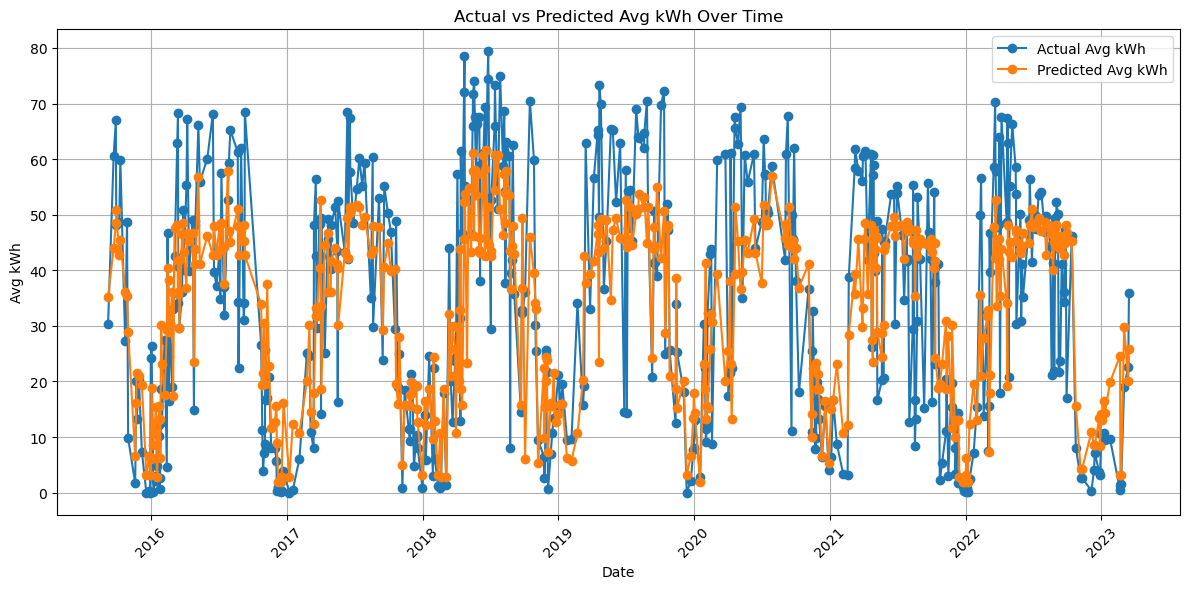

In [111]:
predictions_pd = predictions.select("date", "avg(kWh)", "prediction").toPandas()

# Sorteer per date
predictions_pd = predictions_pd.sort_values('date')

plt.figure(figsize=(12, 6))

plt.plot(predictions_pd['date'], predictions_pd['avg(kWh)'], label='Actual Avg kWh', marker='o')
plt.plot(predictions_pd['date'], predictions_pd['prediction'], label='Predicted Avg kWh', marker='o')

plt.title('Actual vs Predicted Avg kWh Over Time')
plt.xlabel('Date')
plt.ylabel('Avg kWh')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [112]:
predictions_pd

,date,avg(kWh),prediction
217,2015-09-07,30.262947,35.142026
425,2015-09-22,60.640538,44.012140
466,2015-09-28,66.975500,48.436986
325,2015-09-29,48.133000,50.857546
333,2015-10-07,48.744750,42.706529
...,...,...,...
25,2023-02-21,1.394200,3.108558
28,2023-02-23,1.566800,3.112464
156,2023-03-03,19.048694,29.821250
183,2023-03-14,22.599795,20.095008


In [113]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(labelCol="avg(kWh)", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE) bedraagt: {rmse}")

Root Mean Squared Error (RMSE) bedraagt: 13.91236535999109


Dit wil zeggen dat gemiddeld genomen een voorspelling 13,9 units afwijkt van de werkelijke waarde. 

## Conclusie

Dat de temperatuur een sterke correlatie heeft met de seizoenen weten we allemaal wel. Het was in dit  project interessant te zien dat dat dan ook een sterk effect heeft op de productie van zonne-energie. Dit was ergens ook wel te verwachten en in de grafieken is dit duidelijk te zien. Zoals eerder besproken zijn er nog andere kolommen waarvan de gemiddelde energie-productie zeker afhanklijk is, zoals: 

- max visibility
- preciptation/rain/snow en vooral snow_on_ground omdat hier een grote kans is dat de panelen helemaal of gedeeltelijk afgedekt zijn.
- solar_radiation
- sunrise-sunset
- daylight

Eventueel zou er in een uitbreiding van dit project kunnen gezocht worden naar welke factor(en) hierbij het meest bepalend zijn.

Er werd op het einde ook een voorspelling gedaan voor de gemiddelde kWh die opgewekt wordt. Hierbij is de RMSE van 13,9 nog redelijk hoog maar toch acceptabel. Waarschijnlijk zou er een betere score kunnen behaald worden als er ook nog andere features (kolommen) worden meegenomen in het model. 

Het project ging voornamelijk over het al dan niet aantonen van een mogelijk verband tussen de temperatuur en de hoeveelheid energie die wordt opgewekt door zonnepanelen. We kunnen dus concluderen dat er weldegelijk een redelijk sterke correlatie bestaat met een correlatiecoëfficient van 0,68. Dit wil zeggen dat er een positieve lineaire relatie is tussen de twee variabelen. Als de ene variabele toeneemt, is er een tendens dat de andere variabele ook toeneemt. Het getal 0,68 geeft de sterkte van de correlatie aan, maar het vertelt niet hoeveel de ene variabele zal veranderen als de andere met een bepaalde hoeveelheid verandert.

## Lessons learned

In het begin had ik redelijk veel moeite met spark te installeren maar an het volgen van een goede youtube review is het me uiteindelijk toch gelukt. Het inladen en preprocessen ging nog redelijk goed met af en toe moeilijkere dingen. De grote grafieken correct en duidelijk te plotten en daarna met widgets te koppelen heb ik het meeste tijd aan besteed.